In [1]:
import numpy as np
import random
import os
import datetime
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv3D, Flatten, TimeDistributed, 
                                       BatchNormalization, Activation, LSTM, 
                                       MaxPooling3D, MaxPooling2D, Input, Dropout)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)


2025-03-31 08:41:27.055992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743390687.067982   11998 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743390687.072253   11998 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743390687.083412   11998 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743390687.083420   11998 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743390687.083422   11998 computation_placer.cc:177] computation placer alr

In [2]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 4 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [25]:
def generator(source_path, folder_list, batch_size, num_frames):
    """
    Yields batches of video data and one-hot labels.
    
    Each folder entry is assumed to be formatted as "folder_name;other_info;label_index".
    """
    # Constants for video processing
    img_height = 112   # target height
    img_width = 112    # target width
    num_classes = 5    # number of classes
    
    # List of frame indices to use for each video folder
    img_idx = list(range(num_frames))
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        # Process full batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, num_classes), dtype=np.float32)
            
            for i in range(batch_size):
                # "folder_name;other_info;label_index"
                folder_info = t[i + batch * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = cv2.imread(image_path)
                    if image is None:
                        continue  # Skip if the image is not read properly
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (img_width, img_height))
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels
        
        # Process remaining samples (if any)
        remainder = len(t) % batch_size
        if remainder > 0:
            batch_data = np.zeros((remainder, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((remainder, num_classes), dtype=np.float32)
            
            for i in range(remainder):
                folder_info = t[i + num_batches * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = cv2.imread(image_path)
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (img_width, img_height))
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels

In [26]:


# Get the current date and time
curr_dt_time = datetime.datetime.now()
print("Current date and time:", curr_dt_time)

# Define paths for training and validation datasets
train_path = './Project_data/train'
val_path = './Project_data/val'

# Assuming train_doc and val_doc are lists containing the training and validation data
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Choose the number of epochs, here we set it to 10 (modify as needed)
num_epochs = 10
print('# epochs =', num_epochs)


Current date and time: 2025-03-31 08:51:34.097186
# training sequences = 663
# validation sequences = 100
# epochs = 10


In [27]:
def plothistorygraph(history):
    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


In [28]:
# -------------------------
# Model Definition (CNN + LSTM)
# -------------------------
num_frames = 16
img_height = 112
img_width = 112
num_classes = 5

# Input: a sequence of frames
inputs = Input(shape=(num_frames, img_height, img_width, 3))
# TimeDistributed CNN: apply Conv2D on each frame
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Flatten())(x)
# LSTM to capture temporal dynamics
x = LSTM(128, return_sequences=False)(x)
# Dense layers for classification
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 16, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 16, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │    25,756,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,810,245 (98.46 MB)

 Trainable params: 25,810,053 (98.46 MB)

 Non-trainable params: 192 (768.00 B)

In [29]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 16, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 16, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │    25,756,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,810,245 (98.46 MB)

 Trainable params: 25,810,053 (98.46 MB)

 Non-trainable params: 192 (768.00 B)

None


In [30]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# -------------------------
# Training Setup
# -------------------------
batch_size = 2  # Reduce batch size to help mitigate memory issues

# Create tf.data.Dataset from the generator
def get_dataset(source_path, doc, batch_size, num_frames):
    return tf.data.Dataset.from_generator(
        lambda: generator(source_path, doc, batch_size, num_frames),
        output_signature=(
            tf.TensorSpec(shape=(None, num_frames, img_height, img_width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    )

train_dataset = get_dataset(train_path, train_doc, batch_size, num_frames)
val_dataset = get_dataset(val_path, val_doc, batch_size, num_frames)

# Repeat and prefetch datasets
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [31]:
steps_per_epoch = (num_train_sequences // batch_size) + (1 if num_train_sequences % batch_size else 0)
validation_steps = (num_val_sequences // batch_size) + (1 if num_val_sequences % batch_size else 0)

# Callback: Early stopping based on validation loss
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

In [10]:

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    initial_epoch=0
)

Epoch 1/10


I0000 00:00:1743390694.092424   12148 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - categorical_accuracy: 0.2538 - loss: 1.6387 - val_categorical_accuracy: 0.5000 - val_loss: 1.3676
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.4225 - loss: 1.3464 - val_categorical_accuracy: 0.5500 - val_loss: 1.2021
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.5683 - loss: 1.1304 - val_categorical_accuracy: 0.6100 - val_loss: 1.1408
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.7085 - loss: 0.8742 - val_categorical_accuracy: 0.5900 - val_loss: 0.9654
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.8038 - loss: 0.6751 - val_categorical_accuracy: 0.6100 - val_loss: 0.9102
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - categorical_accuracy: 0.9222 - loss: 0.3958 - val_categorical_accuracy: 0.5800 - val_loss: 0.9386
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.9092 - 

Training Accuracy: 0.99%   

Validation Accuracy: 0.66%

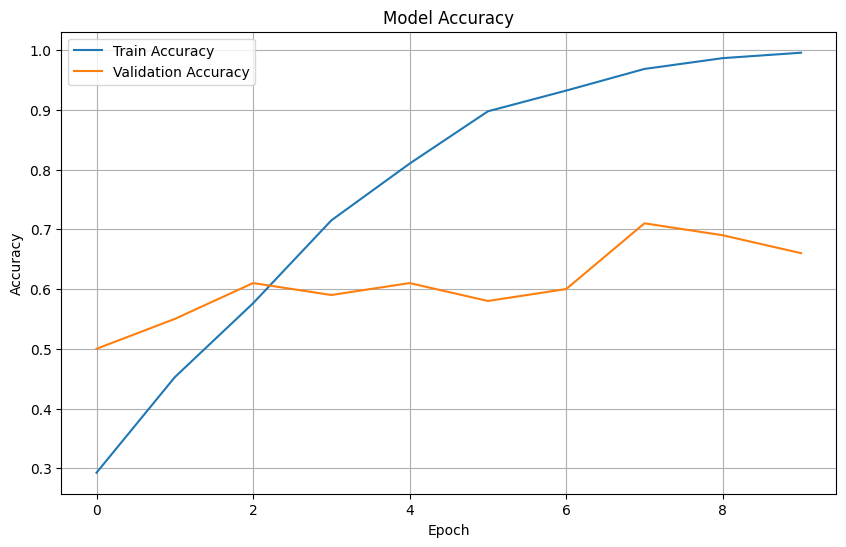

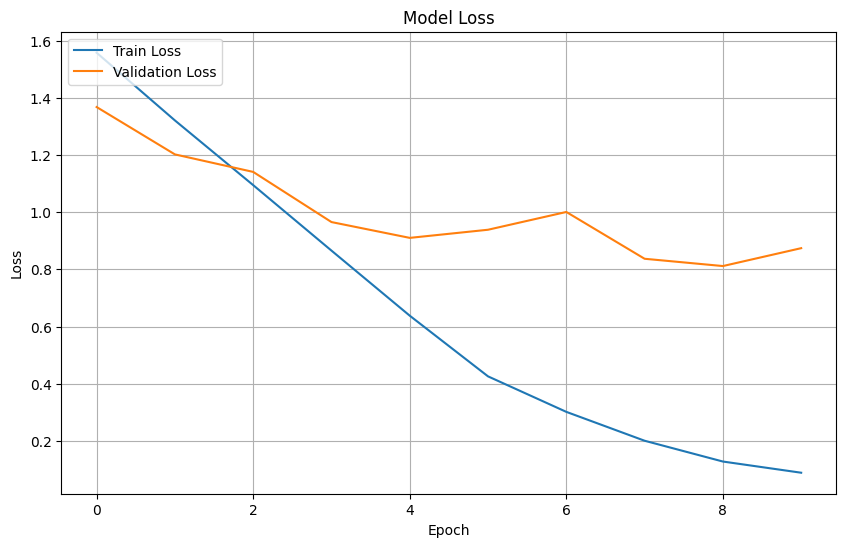

In [11]:
plothistorygraph(history=history)

In [12]:
# Define input dimensions for your video data
num_frames = 15   # Number of frames per video
img_height = 112  # Height of each frame
img_width = 112   # Width of each frame

# Define the input shape (3 channels for RGB)
input_shape = (num_frames, img_height, img_width, 3)

model = Sequential()
# Use an explicit Input layer
model.add(Input(shape=input_shape))

# 1st convolutional block
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(BatchNormalization())

# 2nd convolutional block
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd convolutional block
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Final classification layer - assumes 5 classes
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,971,845 (99.07 MB)

 Trainable params: 25,971,397 (99.07 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,971,845 (99.07 MB)

 Trainable params: 25,971,397 (99.07 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [14]:
# Define your generators
train_generator = generator(train_path, train_doc, batch_size, num_frames=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_frames=num_frames)

In [15]:
# Define model name and create directory if it doesn't exist
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the filepath for saving the model
filepath = model_name + "model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}.h5"

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Define the ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Epoch 1/10


I0000 00:00:1743390857.292855   12137 service.cc:152] XLA service 0x7b2d6c03c710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743390857.292874   12137 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-31 08:44:17.325373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  5/332 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - categorical_accuracy: 0.2767 - loss: 3.5318    

I0000 00:00:1743390860.565530   12137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.3266 - loss: 6.4310
Epoch 1: saving model to model_init_2025-03-3108_41_28.415994/model-01-4.33-0.39.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - categorical_accuracy: 0.3268 - loss: 6.4247 - val_categorical_accuracy: 0.2100 - val_loss: 5.5317 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.6357 - loss: 0.9847
Epoch 2: saving model to model_init_2025-03-3108_41_28.415994/model-02-1.06-0.63.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - categorical_accuracy: 0.6357 - loss: 0.9852 - val_categorical_accuracy: 0.5100 - val_loss: 1.6484 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.7344 - loss: 0.8843
Epoch 3: saving model to model_init_2025-03-3108_41_28.415994/model-03-0.93-0.71.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - categorical_accuracy: 0.7343 - loss: 0.8845 - val_categorical_accuracy: 0.6200 - val_loss: 1.5052 - learning_rate: 1.0000e-04
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.7219 - loss: 0.9532
Epoch 4: saving model to model_init_2025-03-3108_41_28.415994/model-04-0.90-0.75.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - categorical_accuracy: 0.7220 - loss: 0.9530 - val_categorical_accuracy: 0.7500 - val_loss: 1.6770 - learning_rate: 1.0000e-04
Epoch 5/10
329/332 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.7865 - loss: 0.7257
Epoch 5: saving model to model_init_2025-03-3108_41_28.415994/model-05-0.77-0.79.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - categorical_accuracy: 0.7865 - loss: 0.7263 - val_categorical_accuracy: 0.7500 - val_loss: 1.4440 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.8385 - loss: 0.6520
Epoch 6: saving model to model_init_2025-03-3108_41_28.415994/model-06-0.52-0.86.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - categorical_accuracy: 0.8386 - loss: 0.6512 - val_categorical_accuracy: 0.6500 - val_loss: 1.7452 - learning_rate: 1.0000e-04
Epoch 7/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8529 - loss: 0.4162
Epoch 7: saving model to model_init_2025-03-3108_41_28.415994/model-07-0.50-0.84.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - categorical_accuracy: 0.8528 - loss: 0.4169 - val_categorical_accuracy: 0.6900 - val_loss: 1.8654 - learning_rate: 1.0000e-04
Epoch 8/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8344 - loss: 0.7730
Epoch 8: saving model to model_init_2025-03-3108_41_28.415994/model-08-0.74-0.83.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - categorical_accuracy: 0.8344 - loss: 0.7727 - val_categorical_accuracy: 0.6000 - val_loss: 3.6852 - learning_rate: 1.0000e-04
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.8904 - loss: 0.4879
Epoch 9: saving model to model_init_2025-03-3108_41_28.415994/model-09-0.54-0.88.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - categorical_accuracy: 0.8903 - loss: 0.4882 - val_categorical_accuracy: 0.5400 - val_loss: 3.4490 - learning_rate: 1.0000e-04
Epoch 10/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8653 - loss: 0.6090
Epoch 10: saving model to model_init_2025-03-3108_41_28.415994/model-10-0.67-0.87.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - categorical_accuracy: 0.8653 - loss: 0.6092 - val_categorical_accuracy: 0.7100 - val_loss: 2.7437 - learning_rate: 1.0000e-04


Training Accuracy: 0.86%

Validation Accuracy: 0.71%

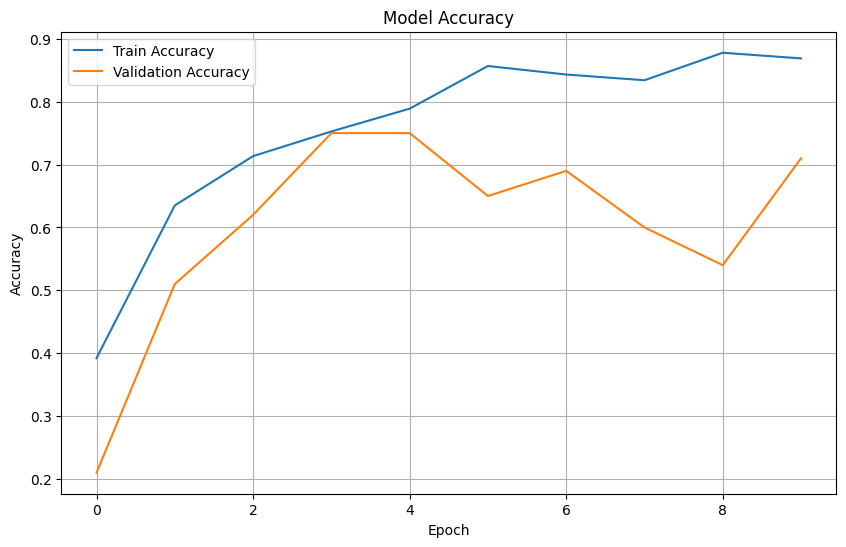

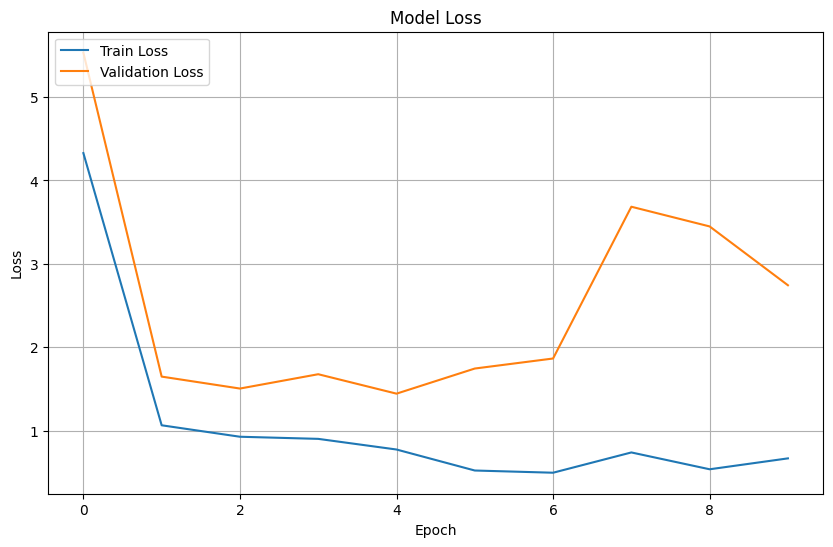

In [18]:
plothistorygraph(history=history)

In [19]:
# Define input dimensions for your video data
num_frames = 25   # Number of frames per video
img_height = 112  # Height of each frame
img_width = 112   # Width of each frame

# Define the input shape (3 channels for RGB)
input_shape = (num_frames, img_height, img_width, 3)

model = Sequential()
# Use an explicit Input layer
model.add(Input(shape=input_shape))

# 1st convolutional block
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(BatchNormalization())

# 2nd convolutional block
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd convolutional block
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Final classification layer - assumes 5 classes
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 25, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 25, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 25, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 13, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 13, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    44,957,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,239,429 (172.57 MB)

 Trainable params: 45,238,981 (172.57 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 25, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 25, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 25, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 13, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 13, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    44,957,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,239,429 (172.57 MB)

 Trainable params: 45,238,981 (172.57 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [21]:
# Define your generators
train_generator = generator(train_path, train_doc, batch_size, num_frames=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_frames=num_frames)

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
# Fit the model
num_epochs = 20 # increased the epochs
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.3485 - loss: 9.1556
Epoch 1: saving model to model_init_2025-03-3108_41_28.415994/model-01-6.13-0.42.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - categorical_accuracy: 0.3487 - loss: 9.1465 - val_categorical_accuracy: 0.2600 - val_loss: 6.4837 - learning_rate: 1.0000e-04
Epoch 2/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.6777 - loss: 1.1730
Epoch 2: saving model to model_init_2025-03-3108_41_28.415994/model-02-1.26-0.67.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - categorical_accuracy: 0.6776 - loss: 1.1738 - val_categorical_accuracy: 0.6000 - val_loss: 1.4617 - learning_rate: 1.0000e-04
Epoch 3/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.6745 - loss: 0.9700
Epoch 3: saving model to model_init_2025-03-3108_41_28.415994/model-03-0.84-0.71.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - categorical_accuracy: 0.6748 - loss: 0.9692 - val_categorical_accuracy: 0.7100 - val_loss: 1.6340 - learning_rate: 1.0000e-04
Epoch 4/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.7707 - loss: 0.8261
Epoch 4: saving model to model_init_2025-03-3108_41_28.415994/model-04-0.87-0.77.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - categorical_accuracy: 0.7707 - loss: 0.8264 - val_categorical_accuracy: 0.6700 - val_loss: 1.5039 - learning_rate: 1.0000e-04
Epoch 5/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.7961 - loss: 0.6979
Epoch 5: saving model to model_init_2025-03-3108_41_28.415994/model-05-0.87-0.78.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - categorical_accuracy: 0.7960 - loss: 0.6989 - val_categorical_accuracy: 0.6900 - val_loss: 2.3624 - learning_rate: 1.0000e-04
Epoch 6/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.8037 - loss: 1.1432
Epoch 6: saving model to model_init_2025-03-3108_41_28.415994/model-06-1.20-0.80.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - categorical_accuracy: 0.8037 - loss: 1.1435 - val_categorical_accuracy: 0.6800 - val_loss: 3.4981 - learning_rate: 1.0000e-04
Epoch 7/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.8201 - loss: 1.1428
Epoch 7: saving model to model_init_2025-03-3108_41_28.415994/model-07-1.24-0.81.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.8201 - loss: 1.1434 - val_categorical_accuracy: 0.7100 - val_loss: 3.3687 - learning_rate: 1.0000e-04
Epoch 8/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.8437 - loss: 0.9585
Epoch 8: saving model to model_init_2025-03-3108_41_28.415994/model-08-0.72-0.87.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.8439 - loss: 0.9563 - val_categorical_accuracy: 0.7900 - val_loss: 1.1605 - learning_rate: 1.0000e-04
Epoch 9/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.9042 - loss: 0.4282
Epoch 9: saving model to model_init_2025-03-3108_41_28.415994/model-09-0.45-0.90.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - categorical_accuracy: 0.9042 - loss: 0.4284 - val_categorical_accuracy: 0.7400 - val_loss: 1.6515 - learning_rate: 1.0000e-04
Epoch 10/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.8850 - loss: 0.4278
Epoch 10: saving model to model_init_2025-03-3108_41_28.415994/model-10-0.29-0.91.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.8853 - loss: 0.4265 - val_categorical_accuracy: 0.8100 - val_loss: 1.3789 - learning_rate: 1.0000e-04
Epoch 11/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9243 - loss: 0.4057
Epoch 11: saving model to model_init_2025-03-3108_41_28.415994/model-11-0.44-0.90.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9241 - loss: 0.4059 - val_categorical_accuracy: 0.7600 - val_loss: 0.9547 - learning_rate: 1.0000e-04
Epoch 12/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.8543 - loss: 0.6756
Epoch 12: saving model to model_init_2025-03-3108_41_28.415994/model-12-0.71-0.86.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.8544 - loss: 0.6759 - val_categorical_accuracy: 0.8300 - val_loss: 0.7103 - learning_rate: 1.0000e-04
Epoch 13/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9032 - loss: 0.5882
Epoch 13: saving model to model_init_2025-03-3108_41_28.415994/model-13-0.64-0.89.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9031 - loss: 0.5885 - val_categorical_accuracy: 0.8400 - val_loss: 1.7202 - learning_rate: 1.0000e-04
Epoch 14/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9020 - loss: 0.5801
Epoch 14: saving model to model_init_2025-03-3108_41_28.415994/model-14-0.63-0.90.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.9020 - loss: 0.5803 - val_categorical_accuracy: 0.8900 - val_loss: 0.8600 - learning_rate: 1.0000e-04
Epoch 15/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9132 - loss: 0.3602
Epoch 15: saving model to model_init_2025-03-3108_41_28.415994/model-15-0.46-0.91.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9131 - loss: 0.3608 - val_categorical_accuracy: 0.8800 - val_loss: 0.5796 - learning_rate: 1.0000e-04
Epoch 16/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9220 - loss: 0.3070
Epoch 16: saving model to model_init_2025-03-3108_41_28.415994/model-16-0.27-0.93.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.9220 - loss: 0.3066 - val_categorical_accuracy: 0.8000 - val_loss: 1.5491 - learning_rate: 1.0000e-04
Epoch 17/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9291 - loss: 0.2978
Epoch 17: saving model to model_init_2025-03-3108_41_28.415994/model-17-0.34-0.93.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.9291 - loss: 0.2981 - val_categorical_accuracy: 0.8600 - val_loss: 1.4644 - learning_rate: 1.0000e-04
Epoch 18/20
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9068 - loss: 0.6575
Epoch 18: saving model to model_init_2025-03-3108_41_28.415994/model-18-0.63-0.90.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.9067 - loss: 0.6573 - val_categorical_accuracy: 0.8400 - val_loss: 0.6214 - learning_rate: 1.0000e-04
Epoch 19/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9196 - loss: 0.3730
Epoch 19: saving model to model_init_2025-03-3108_41_28.415994/model-19-0.44-0.93.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9196 - loss: 0.3732 - val_categorical_accuracy: 0.8200 - val_loss: 1.0843 - learning_rate: 1.0000e-04
Epoch 20/20
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9142 - loss: 0.3485
Epoch 20: saving model to model_init_2025-03-3108_41_28.415994/model-20-0.31-0.93.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - categorical_accuracy: 0.9144 - loss: 0.3482 - val_categorical_accuracy: 0.8500 - val_loss: 0.7623 - learning_rate: 1.0000e-04


Training Accuracy: 0.91%

Validation Accuracy: 0.85%

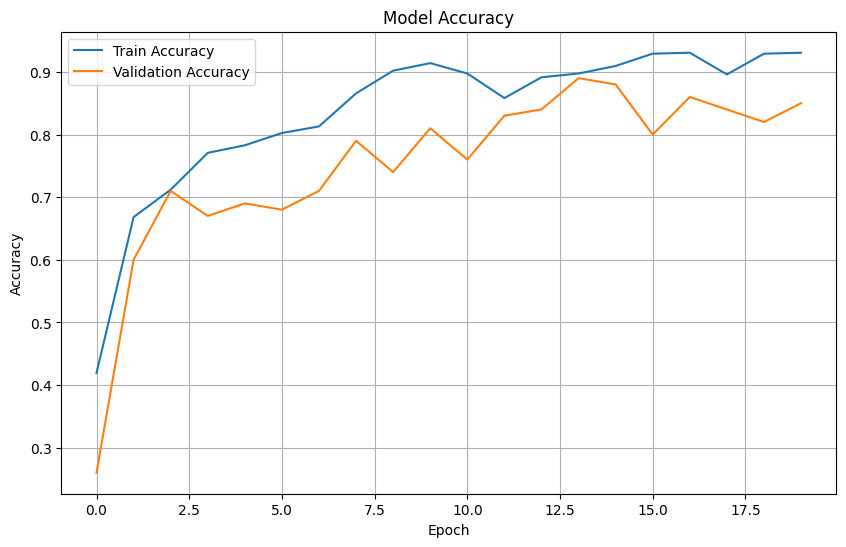

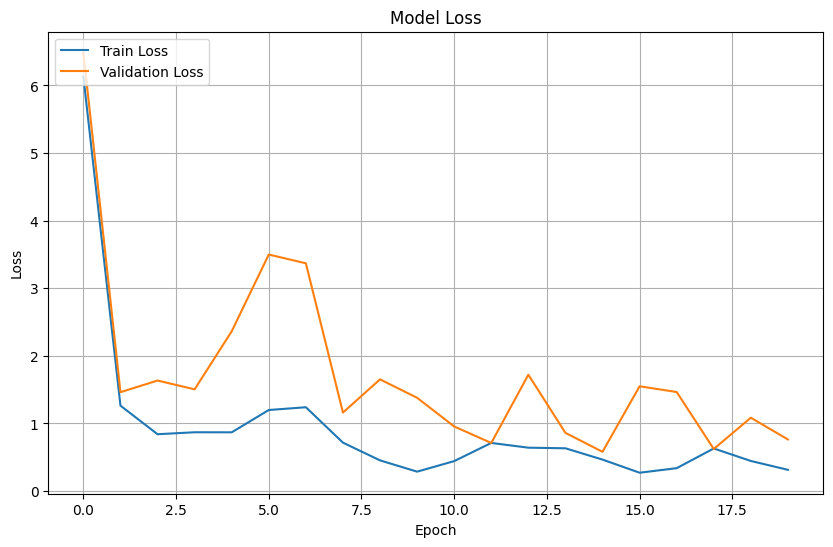

In [24]:
plothistorygraph(history=history)